# Quantifying The Impact of Wildfires on Air Quality in California <br>
## NYU CS-GY 6053, Foundations of Data Science - Fall 2019 Final Project

Team Members: <br>
Alexander Gao (awg297) <br>
Brunnell Velazquez (bv601)

## Project Motivation:<br>

Wildfires are natural disaster events that cause destruction, pose safety and health hazards, and are possibly accelerating in rate due to climate change.  We wish to quantify the impact of wildfires, particularly in the context of air quality, on both a short time-scale (days to weeks), as well as over longer periods of time (months to years).  In this project, we examine air quality data (various pollutants / gas particles) before, during, and after the fire.

Data Science Goal: Generate actionable insights for civil and government officials, and the general public, that will allow them to mitigate health risks of breathing heavily polluted air and be better equipped to navigate safely through these natural disaster events.


In [1]:
# IMPORT LIBRARIES

import os
import re
import sys
import ast
import time

import datetime
from datetime import datetime
from dateutil.parser import parse

import numpy as np
import pandas as pd
from pandas import Series
from pandas.plotting import lag_plot

import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

from statsmodels import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from scipy.signal import detrend
from scipy.optimize import curve_fit

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Datasets

In [0]:
#Load Wildfire and Air Quality datasets
wildfire_df = pd.read_csv('/content/drive/My Drive/Fall 2019/Data Science Project/data/wildfire_data.csv')
aq_df = pd.read_csv('drive/My Drive/Fall 2019/Data Science Project/data/opaq_data_cali.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Munging & Initial Exploration: California Wildfire Dataset

In [0]:
# Remove unnecessary columns
columns_to_drop = list(wildfire_df.columns[21:40]) +\
                  list(wildfire_df.columns[8:10]) +\
                  list(wildfire_df.columns[12:16]) +\
                  [wildfire_df.columns[0], wildfire_df.columns[19], wildfire_df.columns[6]]

wildfire_df = wildfire_df.drop(columns_to_drop, axis=1)

In [0]:
# Format all county names to remove special characters and make lowercase
def format_county(names):
  counties = ast.literal_eval(names)
  if len(counties) != 1: return np.nan
  else: return re.sub('[^0-9a-zA-Z]+', '', counties[0]).lower()

wildfire_df['Counties'] = list(map(lambda x: format_county(x), wildfire_df['Counties']))
wildfire_df = wildfire_df.dropna(subset = ['Counties'], axis = 'rows')
wildfire_df.head(2)

,Name,Location,Latitude,Longitude,AcresBurned,PercentContained,Counties,CountyIds,Started,Extinguished,ArchiveYear,Active
0,Becks Fire,"North of Highway 29, southeast of Kelseyville",0.000000,0.00000,296.0,100.0,lake,17,2013-01-22T11:08:00Z,2013-01-23T10:15:00Z,2013,False
1,River Fire,"south of Narrow Gauge Rd & north of Hwy 136, e...",36.602575,-118.01651,406.0,100.0,inyo,14,2013-02-24T08:16:00Z,2013-02-28T20:00:00Z,2013,False


In [0]:
print("TOTAL NUMBER OF ROWS IN WILDFIRE DATASET:", len(wildfire_df['Latitude']))

TOTAL NUMBER OF ROWS IN WILDFIRE DATASET: 1584


In [0]:
# Count the number of unique counties contained in wildfire data
counties = np.array(wildfire_df["Counties"])
unique_counties, counts = np.unique(counties, return_counts=True)
print("WILDFIRE DATASET: TOTAL NUMBER OF UNIQUE COUNTIES: ", len(unique_counties))
unique_counties

WILDFIRE DATASET: TOTAL NUMBER OF UNIQUE COUNTIES:  59


array(['alameda', 'alpine', 'amador', 'butte', 'calaveras', 'colusa',
       'contracosta', 'delnorte', 'eldorado', 'fresno', 'glenn',
       'humboldt', 'inyo', 'kern', 'kings', 'lake', 'lassen',
       'losangeles', 'madera', 'marin', 'mariposa', 'mendocino', 'merced',
       'mexico', 'modoc', 'mono', 'monterey', 'napa', 'nevada', 'orange',
       'placer', 'plumas', 'riverside', 'sacramento', 'sanbenito',
       'sanbernardino', 'sandiego', 'sanjoaquin', 'sanluisobispo',
       'sanmateo', 'santabarbara', 'santaclara', 'santacruz', 'shasta',
       'sierra', 'siskiyou', 'solano', 'sonoma', 'stanislaus',
       'stateofnevada', 'stateoforegon', 'sutter', 'tehama', 'trinity',
       'tulare', 'tuolumne', 'ventura', 'yolo', 'yuba'], dtype=object)

The next step toward understanding the wildfire data is to assess which counties have been most impacted by wildfires in a quantitative way.  We analyze the following metrics, per California county in the dataset (2013 - 2019):

  - \# of Wildfires / County
  - Acres Burned / County
  - Average Wildfire Size (acres) / County

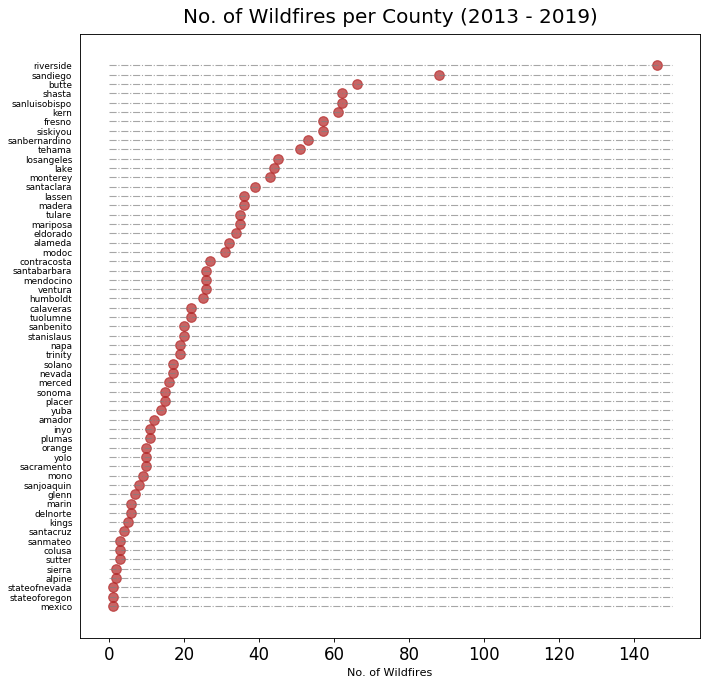

In [0]:
# COUNT WILDFIRES PER COUNTY
count_df = pd.DataFrame({'Counties': unique_counties, 'No. of Wildfires': counts})
count_df.sort_values('No. of Wildfires', inplace=True)
count_df.reset_index(inplace=True)

# Draw plot
fig, ax = plt.subplots(figsize=(10, 10), dpi = 80)
ax.hlines(y=count_df.index, xmin=0, xmax=150, color='gray', alpha = 0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=count_df.index, x=count_df['No. of Wildfires'], s = 75, color='firebrick', alpha=0.7)

ax.set_title("No. of Wildfires per County (2013 - 2019)", fontdict={'size' : 18})
ax.set_xlabel('No. of Wildfires')
ax.set_yticks(count_df.index)
ax.set_yticklabels(count_df['Counties'], fontdict={'horizontalalignment' : 'right', 'size' : 8})

plt.show()

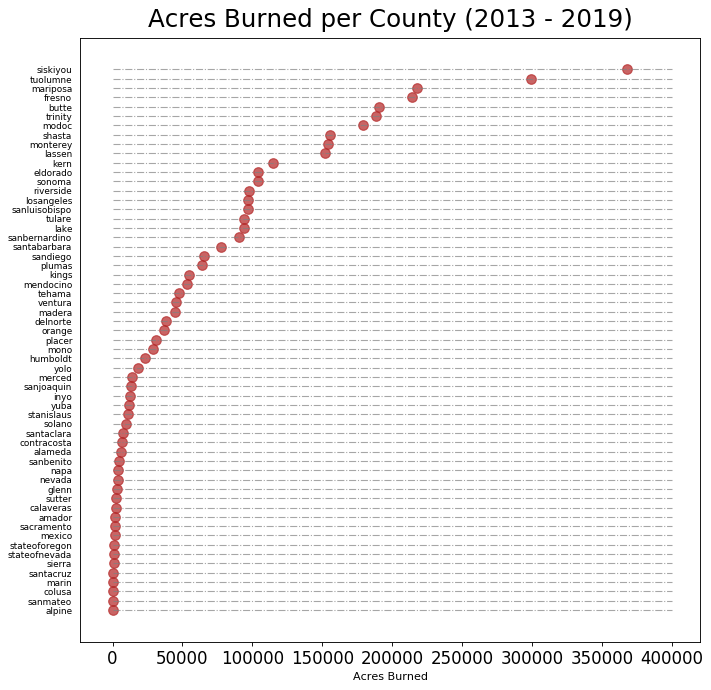

In [0]:
# COUNT TOTAL ACRES BURNED PER COUNTY
acres_df = wildfire_df[['Counties', 'AcresBurned',]].groupby('Counties').sum()
acres_df.sort_values('AcresBurned', inplace=True)
acres_df.reset_index(inplace=True)

# Draw plot
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80)
ax.hlines(y=acres_df.index, xmin=0, xmax=400000, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=acres_df.index, x=acres_df.AcresBurned, s=75, color='firebrick', alpha=0.7)

ax.set_title('Acres Burned per County (2013 - 2019)', fontdict={'size' : 22})
ax.set_xlabel('Acres Burned')
ax.set_yticks(acres_df.index)
ax.set_yticklabels(acres_df['Counties'], fontdict={'horizontalalignment' : 'right', 'size' : 8})

plt.show()

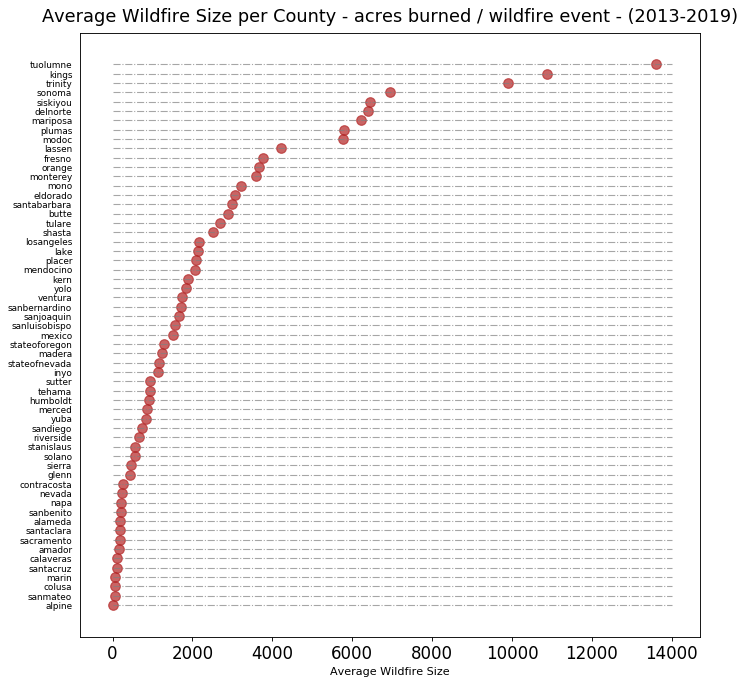

In [0]:
# AVERAGE WILDFIRE SIZE PER COUNTY
average_size_df = wildfire_df[['Counties', 'AcresBurned',]].groupby('Counties').sum()
average_size_df['num_wildfires'] = counts
average_size_df['average_size'] = np.array(average_size_df['AcresBurned']) / np.array(average_size_df['num_wildfires'])
average_size_df.sort_values('average_size', inplace = True)
average_size_df.reset_index(inplace=True)

#Draw plot
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80)
ax.hlines(y = average_size_df.index, xmin = 0, xmax = 14000, color = 'gray', alpha = 0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y = average_size_df.index, x = average_size_df['average_size'], s=75, color='firebrick', alpha=0.7)

ax.set_title("Average Wildfire Size per County - acres burned / wildfire event - (2013-2019)", fontdict={'size':16})
ax.set_yticklabels(average_size_df['Counties'], fontdict={'horizontalalignment' : 'right', 'size' : 8})
ax.set_xlabel('Average Wildfire Size')
ax.set_yticks(average_size_df.index)

plt.show()

In [0]:
# Create DataFrame with county, aggregate number of wildfires
count_df = pd.DataFrame({'Counties': unique_counties, 'No. of Wildfires': counts})

# Create DataFrame with county, total acres burned
acres_df = wildfire_df[['Counties', 'AcresBurned',]].groupby('Counties').sum()

In [0]:
# SORT count_df and acres_df
count_df = count_df.sort_values('Counties', ascending=False)
count_df.reset_index(inplace=True, drop=True)

acres_df = acres_df.sort_values('Counties', ascending=False)
acres_df.reset_index(inplace=True)

Is there any correlation between the "Number of Wildfires" and "Number of Acres Burned Per County" ?


Covariance matrix:


,No. of Wildfires,AcresBurned
No. of Wildfires,1.000000,0.487009
AcresBurned,0.487009,1.000000


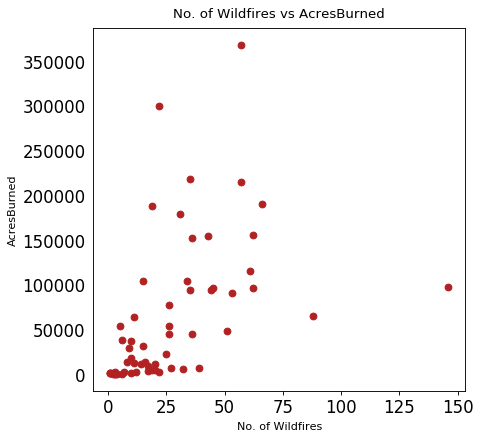

In [0]:
plt.subplots(figsize=(6, 6), dpi= 80)
plt.plot(count_df["No. of Wildfires"], acres_df['AcresBurned'], linestyle='none', marker='o', color='firebrick')
plt.title("No. of Wildfires vs AcresBurned")
plt.xlabel("No. of Wildfires")
plt.ylabel('AcresBurned')
plt.show()

combined = pd.DataFrame({"No. of Wildfires": count_df["No. of Wildfires"], 'AcresBurned': acres_df['AcresBurned']})
print("\nCovariance matrix:")
corr = combined.corr()
corr

Before we go further into exploring the data, we need to process the Air Quality dataset, and eventually will need to find the intersection of these datasets in order to establish a correlation between wildfire events and measurable changes in air quality.


.

# Data Munging & Initial Exploration: California Air Quality Dataset


In [0]:
aq_df = aq_df.drop(['attribution', 'averagingperiod', 'coordinates', 'country', 'sourcename', 'sourcetype', 'mobile'], axis = 1)

In [0]:
# Format all city and location names to remove special characters and make lowercase

def format_str(name):
  return re.sub('[^0-9a-zA-Z]+', '', name).lower()

aq_df = aq_df.dropna(subset = ['city', 'location'], axis = 'rows')
aq_df['city'] = list(map(lambda x: format_str(x), aq_df['city']))
aq_df['location'] = list(map(lambda x: format_str(x), aq_df['location']))
aq_df.head()

,date,parameter,location,value,unit,city
0,"{utc=2017-09-05T17:00:00.000Z, local=2017-09-0...",pm25,huron,13.000,µg/m³,fresno
1,"{utc=2017-09-05T17:00:00.000Z, local=2017-09-0...",o3,tranquillity,0.036,ppm,fresno
2,"{utc=2017-09-05T17:00:00.000Z, local=2017-09-0...",pm25,tranquillity,4.000,µg/m³,fresno
3,"{utc=2017-09-05T17:00:00.000Z, local=2017-09-0...",o3,clovisnvillaav,0.043,ppm,fresno
4,"{utc=2017-09-05T17:00:00.000Z, local=2017-09-0...",o3,hanfordsirwins,0.040,ppm,hanfordcorcoran


In [0]:
#Identify the unique values in dataset
cities, locations, measured, unit = aq_df.city.unique(), aq_df.location.unique(), aq_df.parameter.unique(), aq_df.unit.unique()

param_unit = {}

for i in range(len(aq_df.parameter)):
  param_unit[aq_df.parameter[i]] = aq_df.unit[i]
  if len(list(param_unit.keys())) == len(measured):
    break

print("NUMBER OF UNIQUE CITIES: ", len(cities))
print("NUMBER OF UNIQUE LOCATIONS: ", len(locations))
print("UNIT OF MEASUREMENT FOR EACH POLLUTANT: ", param_unit)

NUMBER OF UNIQUE CITIES:  60
NUMBER OF UNIQUE LOCATIONS:  156
UNIT OF MEASUREMENT FOR EACH POLLUTANT:  {'pm25': 'µg/m³', 'o3': 'ppm', 'pm10': 'µg/m³', 'bc': 'µg/m³', 'no2': 'ppm', 'co': 'ppm', 'so2': 'ppm'}


Generate Air Quality Time Sequences for Each County and Location, and write to disk, so that the data can easily be accessed later during exploration:


In [0]:
# DELIBERATELY COMMENTED OUT - NO NEED TO RERUN UNLESS INTENTIONAL CHANGES MUST BE MADE TO WRITTEN OUT CSV FILES

#df_dict = {}

#aq_df_cities = aq_df.groupby('city')    

#for city in cities:
    #print(city)
    #try:
        #city_regex = re.sub('[^0-9a-zA-Z]+', '', city)
        #city_df = aq_df_cities.get_group(city)
        #city_df = city_df.groupby('parameter')
        #params = city_df.parameter.unique()

        #for param in params:
            #loc_param_df_name = city_regex + '_' + param[0] + '_' + 'df'
            #loc_param_df = city_df.get_group(param[0])
            #loc_param_df['date'] = list(map(lambda x: x[5:29], loc_param_df['date']))
            #loc_param_df = loc_param_df.sort_values(['date'])
            #loc_param_df['date'] = pd.to_datetime(loc_param_df['date'])
            #df_dict[loc_param_df_name] = loc_param_df
    #except: print("Not a valid entry.")

#for each in df_dict.keys():
    #print(each)
    #outpath = '../data/aq_timeseries/by_city/' + each + '.csv'
    #df_dict[each].to_csv(outpath)

.

# Cross-Referencing Wildfire and AQ Datasets

The California Wildfire and Air Quality datasets are not uniform.  They differ in the locations that are included in each, the timeframes over which the data spans, and various other irregularities.  The following work references the datasets against each other and finds the intersection of the two -- leaving us with a subset of the datasets that includes instances of wildfires in California for which we have Air Quality data.


In [0]:
aq_cities = cities
aq_locations = locations

all_locations = list(set(np.concatenate((aq_cities, aq_locations))))
all_locations = [re.sub('[^0-9a-zA-Z]+', '', location) for location in all_locations]

all_locations.sort()
aq_locations.sort()
aq_cities.sort()

In order to find the intersection of the datasets, we create a map of locations found in one dataset to locations found in the other dataset, by comparing location names.
(Not every location is common to both datasets)

In [0]:
# :<key, value>: <wf_location, list(aq_cities)> 

wf_aq_map = {}

for wf_location in unique_counties:
  wf_aq_map[wf_location] = []

  for aq_city in all_locations:
    if wf_location in aq_city or aq_city in wf_location:
      wf_aq_map[wf_location].append(aq_city)

wf_aq_map

{'alameda': ['alameda'],
 'alpine': ['alpine'],
 'amador': [],
 'butte': ['butte'],
 'calaveras': ['calaveras'],
 'colusa': ['colusa', 'colusasunriseblv', 'willowscolusa'],
 'contracosta': [],
 'delnorte': [],
 'eldorado': [],
 'fresno': ['fresno', 'fresnogarland'],
 'glenn': ['glenn'],
 'humboldt': ['humboldt', 'humboldthill'],
 'inyo': ['inyo'],
 'kern': ['kern', 'kernville'],
 'kings': [],
 'lake': ['crestlinelakegre',
  'lakeelsinorewf',
  'mammothlakes',
  'temeculalakeskinn'],
 'lassen': [],
 'losangeles': ['losangeles', 'losangeleslongbeachsantaana', 'losangelesnmai'],
 'madera': ['madera', 'maderacity'],
 'marin': [],
 'mariposa': ['mariposa'],
 'mendocino': ['mendocino'],
 'merced': ['merced', 'mercedscoffeea'],
 'mexico': [],
 'modoc': [],
 'mono': ['mono'],
 'monterey': ['monterey'],
 'napa': ['napa', 'napajeffersonst', 'napanapavalleyc'],
 'nevada': [],
 'orange': [],
 'placer': ['placer'],
 'plumas': ['plumas'],
 'riverside': ['riverside',
  'riversiderubidoux',
  'riversi

# Data Exploration and Visualization

In [0]:
def plot_acresburned(wildfire_df, county, start_index = 0, end_index = sys.maxsize, years = None):
  """
  Creates a bar graph of acres burned in a particular county, over a given range of time.

  :param county: type(str)
  :param start_index: type(int)
  :param start_index: type(int)
  :param start_index: type(list(int, int))
  """
  plt.close('all')

  filtered_df = wildfire_df.loc[wildfire_df["Counties"] == county]

  dates = [date[:10] for date in np.array(filtered_df['Started'])]
  acres = filtered_df['AcresBurned'].tolist()

  to_plot = pd.DataFrame({'Date': dates, 'AcresBurned': acres})
  to_plot.head()
      
  if years == None:
      dt = pd.to_datetime(to_plot['Date'], exact=False, yearfirst=True).tolist()
      if start_index !=None and end_index !=None:
        to_plot = to_plot.iloc[start_index : end_index]
  else:
      dt = pd.to_datetime(to_plot['Date'], exact=False, yearfirst=True).tolist()
      is_year = [i.year in years for i in dt]
      to_plot = to_plot[is_year] 
      dt = pd.to_datetime(to_plot['Date'], exact=False, yearfirst=True).tolist()
    
  try:
    startDate = dt[max(0, start_index)].strftime("%x")
    endDate = dt[min(len(dates) - 1, end_index)].strftime("%x")
  except:
    print("Acres Burned Plot: Invalid Start / End Time. Skipping this one.")
    return

  plt.xticks(rotation=90)
  plt.bar(to_plot['Date'], to_plot['AcresBurned'])
  plt.title(f"Acres Burned in {county.upper()} from {startDate} - {endDate}", fontsize=30)
  plt.xlabel('DATE', fontsize = 13)
  plt.ylabel('ACRES BURNED', fontsize = 20)
  plt.rcParams['figure.figsize'] = [20, 12] 
  plt.rc('xtick', labelsize = 20) 
  plt.rc('ytick', labelsize = 15) 
  plt.tick_params(axis="x", direction="in")
  plt.tick_params(axis="y", direction="inout")


  # Write graph as image to disk
  outpath = '/content/drive/My Drive/Fall 2019/Data Science Project/results/acresburned_plots/' + county + "_acresburned.png"

  try:
    plt.savefig(outpath)
    print("Acres-Burned plot successfully saved to disk.")  
  except:
    print("There was an error saving Acres-Burned plot to disk.")

In [0]:
def plot_timeseries(location, gas, start_index = 0, end_index = sys.maxsize, smoothing_window_size = 0, d=param_unit):
    """
    1. Fills in missing time indexes (by hour) using linear interpolation.
    2. Plots timeseries from the range 'start_index' to 'end_index'.
    3. Plots smoothed timeseries, using specific moving average window size
    
    :param location: type(str)
    :param gas: type(str)
    :param smoothing_window_size: if 0, no smoothing will be applied/shown
    :return: interpolated, smoothed df
    """
    plt.close('all')
    outpath = '/content/drive/My Drive/Fall 2019/Data Science Project/results/aq_plots/' + location + '_' + gas + '.png'
    location = re.sub('[^0-9a-zA-Z]+', '', location) #REGEX
    
    try:
        datapath = '/content/drive/My Drive/Fall 2019/Data Science Project/data/aq_timeseries/by_city/' + location + '_' + gas + '_df.csv'
        print(datapath)
        df = pd.read_csv(datapath)
    except:
        try:
            datapath = '/content/drive/My Drive/Fall 2019/Data Science Project/data/aq_timeseries/by_location/' + location + '_' + gas + '_df.csv'
            df = pd.read_csv(datapath)
        except:
            print("This timeseries was not found.  Please make sure the data exists.")
            return

    dates = np.array(df['date']).astype(np.datetime64)[start_index : min(end_index, df.shape[0])]
    values = np.array(df['value'])[start_index : min(end_index, df.shape[0])]

    try:
        data = pd.Series(values, dates).resample('h').interpolate()
    except:
        data = pd.Series(values, dates)
        
    start_date = pd.to_datetime(dates[0]).strftime("%m-%Y")
    end_date = pd.to_datetime(dates[min(end_index, df.shape[0]) - start_index - 1]).strftime("%m-%Y")
    plot_title = location + " - " + gas + f" Measurement ({d[gas]}) " + "(" + start_date + " - " + end_date + ")"
    smoothing_label = f"Moving Average, window_size = {smoothing_window_size} previous hours"
    ylabel = gas + f' MEASUREMENT ({d[gas]})'
    
    plt.title(plot_title, fontsize=30)
    plt.xlabel('DATE', fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    plt.rcParams['figure.figsize'] = [20, 12] 
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    plt.tick_params(axis="x", direction="in")
    plt.tick_params(axis="y", direction="inout")
    plt.xticks(rotation=90)
    plt.grid()
    
    plt.plot(data, color = 'orange', label = "Raw Measurements (Interpolated for missing values)")
    
    if smoothing_window_size:
        data_rolling_avg = data.rolling(smoothing_window_size).mean()
        plt.plot(data_rolling_avg, label = smoothing_label, color = 'blue')
    
    plt.legend(fontsize = 'xx-large')

    try:
      plt.savefig(outpath)
      print("Plot successfully saved to disk.")  
    except:
      print("There was an error saving plot to disk.")
      
    if smoothing_window_size:
      return data, data_rolling_avg
    else:
      return data

In [0]:
def plot_graphs(wf_location, aq_locations, smoothing_window_size = 100):
  pollutants = ['pm25', 'o3', 'pm10', 'bc', 'no2', 'co', 'so2']

  for aq_location in aq_locations:
    plot_acresburned(wildfire_df, aq_location)
    for pollutant in pollutants:
      plot_timeseries(aq_location, pollutant, smoothing_window_size = smoothing_window_size)

We would like to validate that the occurrence of a wildfire event is directly correlated with the rise in air pollutants.  We will first examine the measurement of pm25 (fine particulate matter) in the air to demonstrate this correlation.

Acres-Burned plot successfully saved to disk.


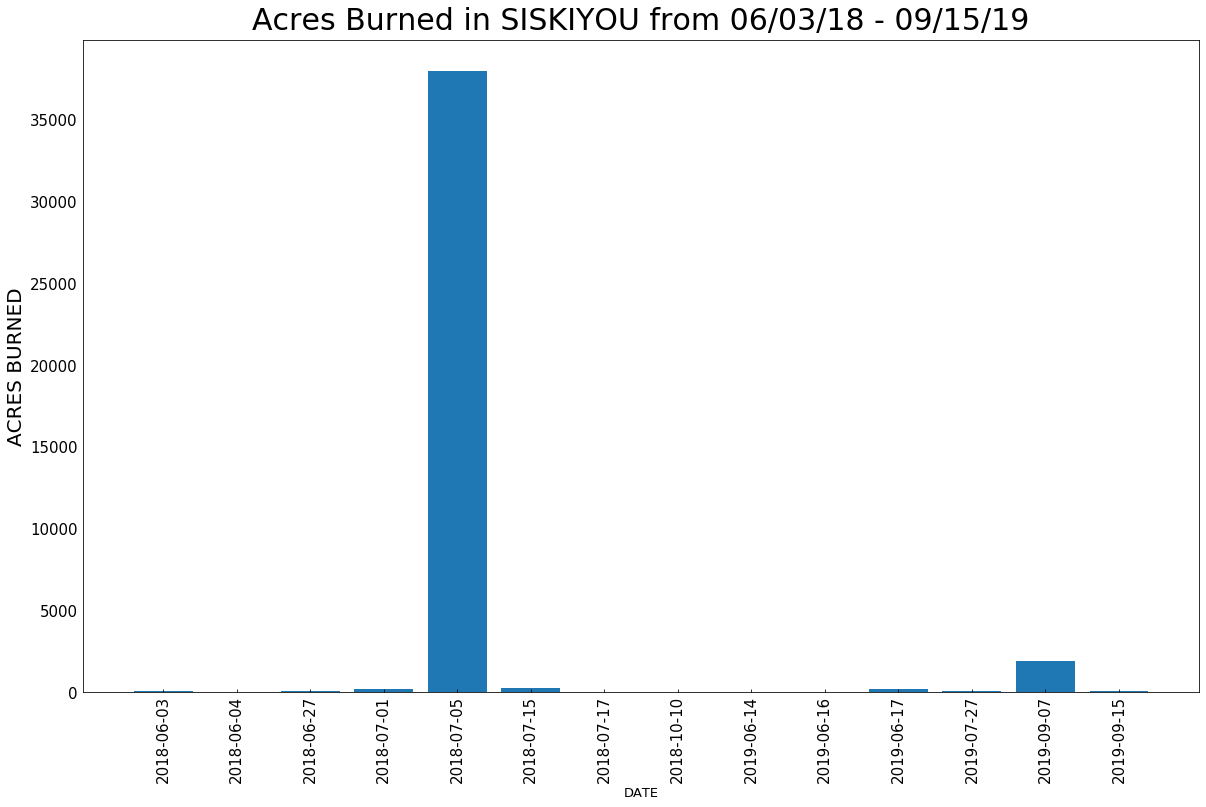

In [0]:
plot_acresburned(wildfire_df, 'siskiyou', 40)

/content/drive/My Drive/Fall 2019/Data Science Project/data/aq_timeseries/by_city/siskiyou_pm25_df.csv
Plot successfully saved to disk.


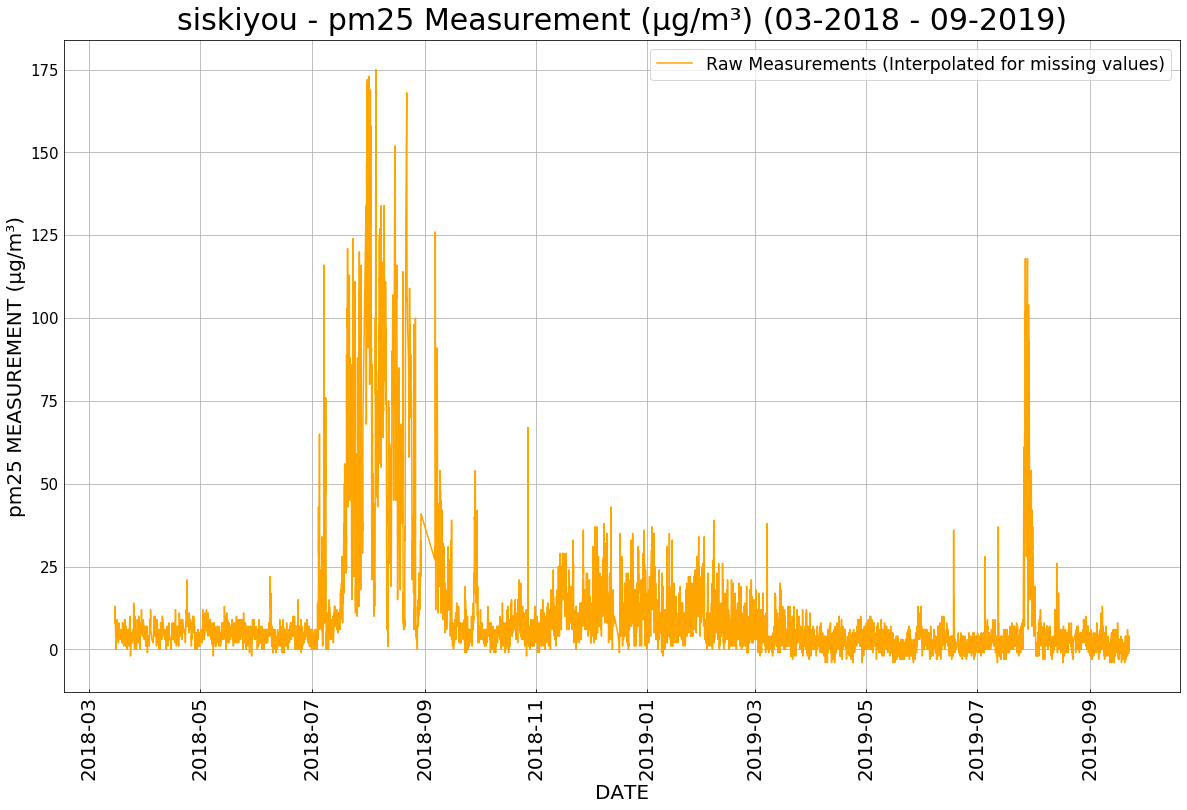

In [0]:
siskiyou_pm25_avg_df = plot_timeseries('siskiyou', 'pm25', 100, 11600)

The correlation between acres burned and rise in level of pm25 can be clearly observed from the above graphs.

.

### Examining Autocorrelation, and its Implications

We examine autocorrelation for 'pm25' and 'o3' gases, and derive different insights based on the results of each ACF Plot.

Below, the autocorrelation plot for 'pm25' for a single large wildfire event that happened in Siskiyou, California in August 2019.  Since there is an overall trend in the timeseries as the gas dissipates, the timeseries has been stationarized in order to properly examine the autocorrelation.  Our motivation for looking at autocorrelation of this timeseries is primarily exploratory -- we are looking to understand whether there is any short-term "seasonality" to the dissipation of the particles, and whether the visually apparent "noise" in the timeseries is actually just random/white noise / variance in the pm25 sensor measurements, or if there is more potential "meaning" in the fluctuations.

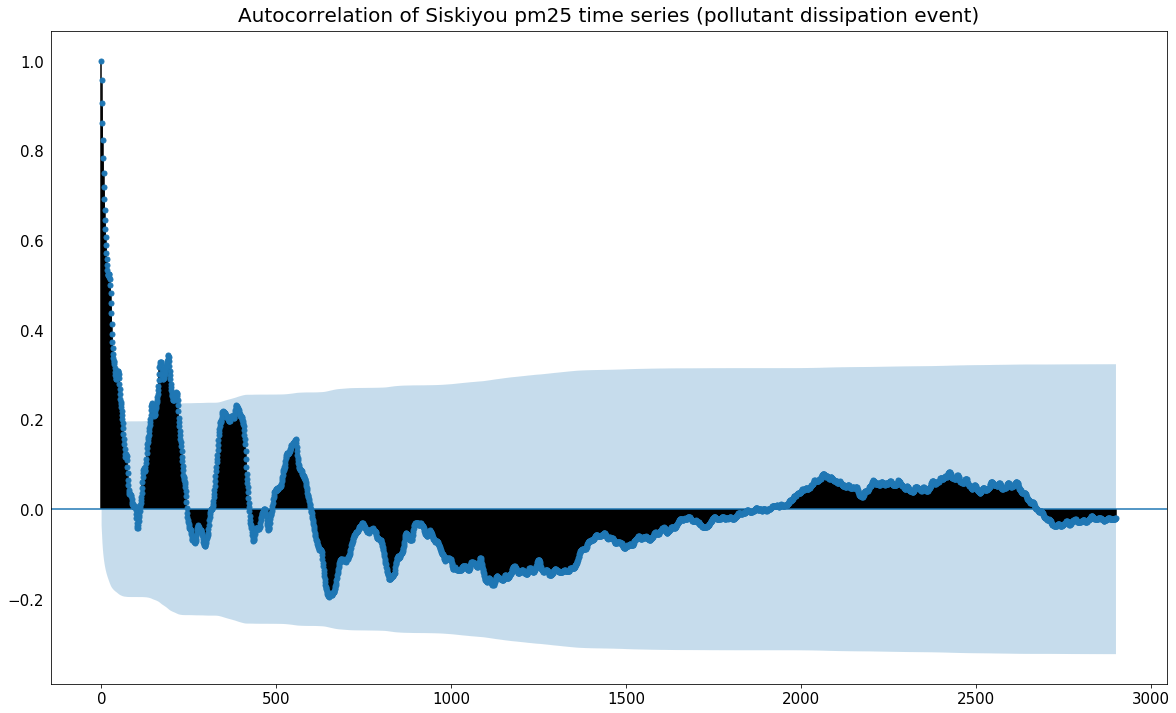

In [0]:
stationary_siskiyou_pm25_data = detrend(siskiyou_pm25_avg_df[3000 : 6000])
plot_acf(stationary_siskiyou_pm25_data, lags = 2900)
plt.title("Autocorrelation of Siskiyou pm25 time series (pollutant dissipation event)", fontsize = 20)
plt.show()

Next, we look at the Lag Plot for the same timeseries:

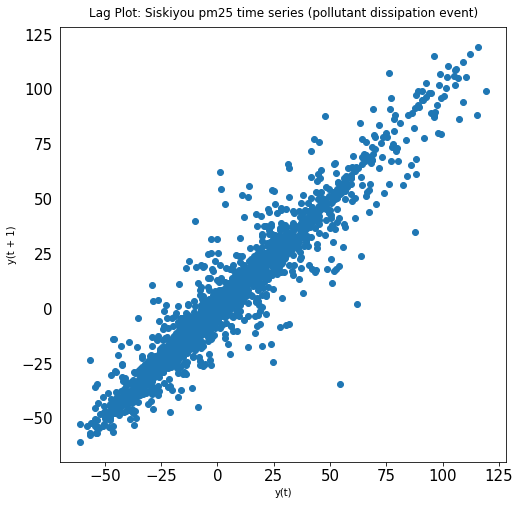

In [0]:
plt.figure(figsize = (8, 8))
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
lag_plot(pd.DataFrame(stationary_siskiyou_pm25_data))
plt.title("Lag Plot: Siskiyou pm25 time series (pollutant dissipation event)", fontsize = 12)

plt.show()

From the plot, we infer that the timeseries, while it does not exbihit any strong seasonality or other clearly interpretable pattern, the fluctuations in measurements are not simply random white noise from the sensor.  The fluctuations might be related to a combination of factors.  From the data, it is not possible to derive a sense of causation for the fluctuations, however based on pure speculation, perhaps they have some correlation with geography, weather conditions, firefighting infrastructure in a given location, etc. 

Next, we examine the autocorrelation for a different gas, 'o3', also known as ozone.  We will use a different location, but the seasonality pattern we notice in this series seems to fit other 'o3' timeseries very consistently.  From first glance, it seems that o3 levels fluctuate based on season, with peaks in summertime months, and lows in wintertime months.  Again, it is difficult to determine exact causation, but we speculate that the seasonality of ozone may be related to the hotter temperatures in summertime:

/content/drive/My Drive/Fall 2019/Data Science Project/data/aq_timeseries/by_city/napa_o3_df.csv
Plot successfully saved to disk.


(2016-03-06 19:00:00    0.043000
 2016-03-06 20:00:00    0.042000
 2016-03-06 21:00:00    0.041889
 2016-03-06 22:00:00    0.041778
 2016-03-06 23:00:00    0.041667
                          ...   
 2019-11-14 19:00:00    0.035000
 2019-11-14 20:00:00    0.031000
 2019-11-14 21:00:00    0.027000
 2019-11-14 22:00:00    0.030000
 2019-11-14 23:00:00    0.032000
 Freq: H, Length: 32357, dtype: float64, 2016-03-06 19:00:00        NaN
 2016-03-06 20:00:00        NaN
 2016-03-06 21:00:00        NaN
 2016-03-06 22:00:00        NaN
 2016-03-06 23:00:00        NaN
                         ...   
 2019-11-14 19:00:00    0.02302
 2019-11-14 20:00:00    0.02319
 2019-11-14 21:00:00    0.02328
 2019-11-14 22:00:00    0.02337
 2019-11-14 23:00:00    0.02340
 Freq: H, Length: 32357, dtype: float64)

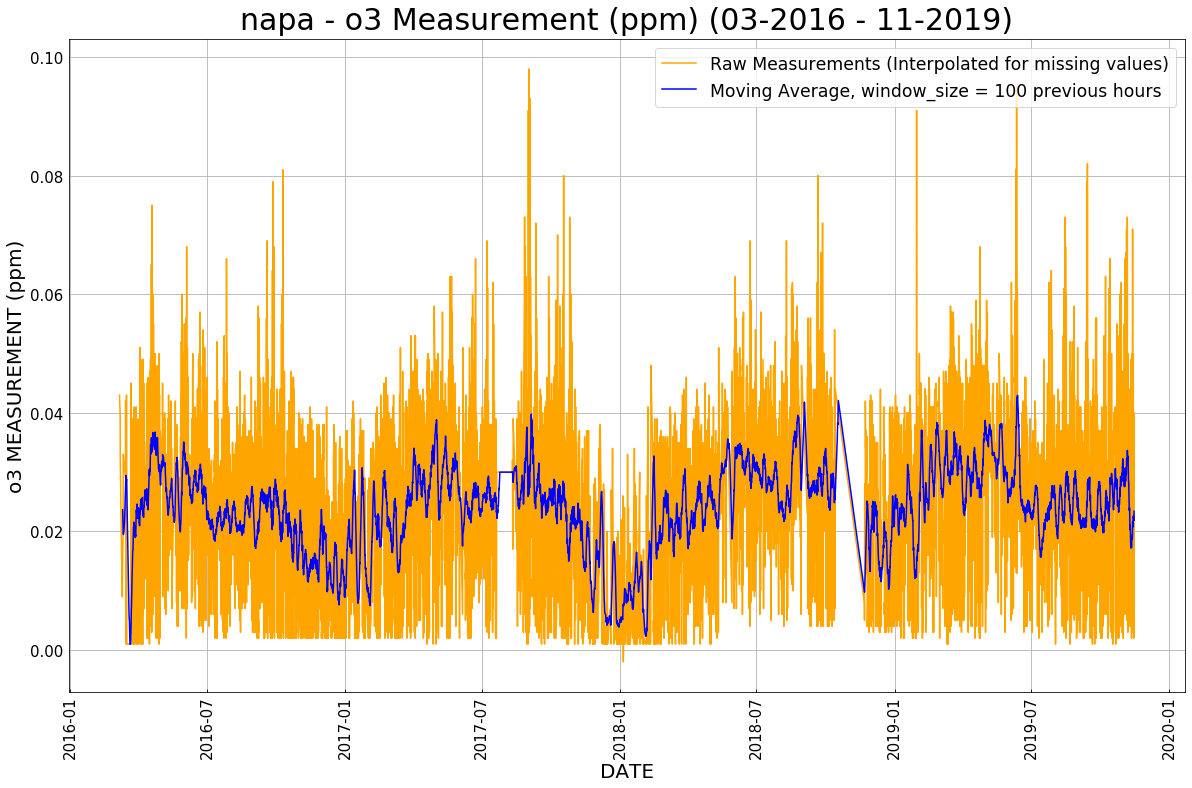

In [0]:
plot_timeseries('napa', 'o3', smoothing_window_size = 100)

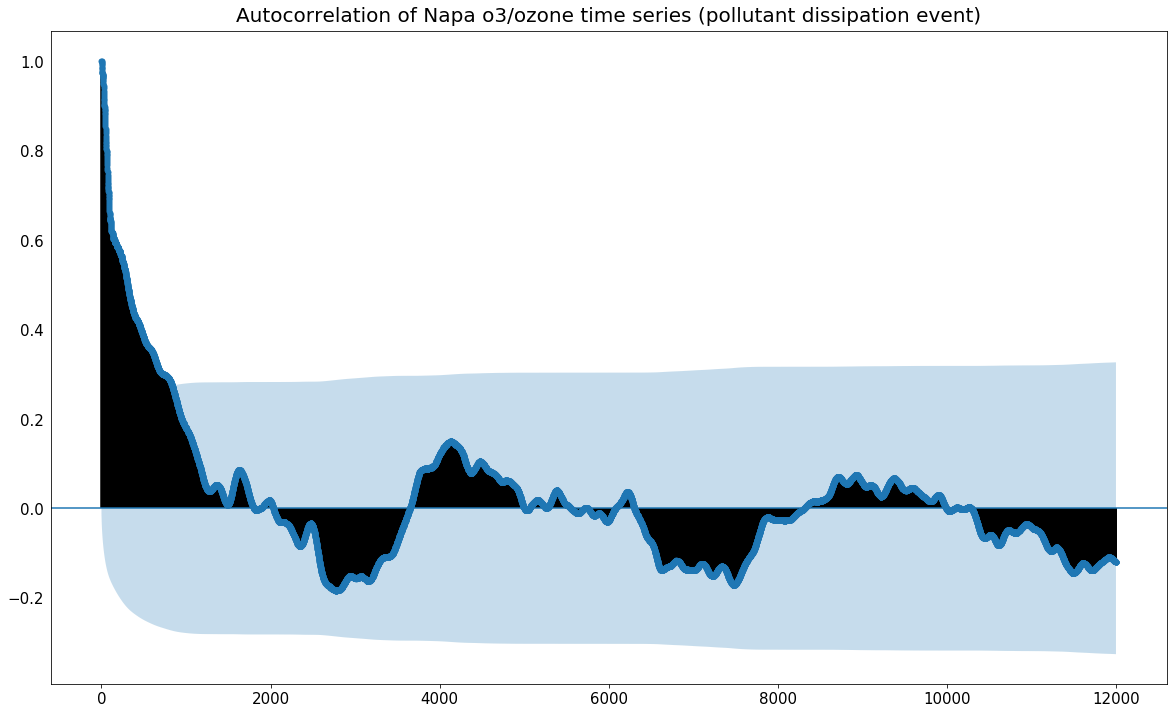

In [0]:
napa_o3_data = pd.read_csv('/content/drive/My Drive/Fall 2019/Data Science Project/data/aq_timeseries/by_city/napa_o3_df.csv')['value']
napa_o3_rolling_avg = napa_o3_data.rolling(100).mean()
napa_o3_rolling_avg = napa_o3_rolling_avg[~np.isnan(napa_o3_rolling_avg)]
plot_acf(napa_o3_rolling_avg, lags = 12000)
plt.title("Autocorrelation of Napa o3/ozone time series (pollutant dissipation event)", fontsize = 20)
plt.show()

The autocorrelation plot confirms seasonality of ozone levels.  Based on our above observations, and intutive interpretations of plots of the 6 different gases (that can be found in 'results/aq_plots/'), we wish to focus on a single gas (pm25) for the purpose of this project.  In the future, given additional resources and time, we would continue to analyze all of the different gases.<br><br>
### Intuition begin our choice to focus on pm25:<br>
We choose to focus on pm25 because the corresponding timeseries contain a robust signal response to wildfire events.  Also, pm25 levels generally hover at a low level without major fluctuations, exceopt when there are wildfires.  This establishes a reliable "baseline" that we use as the basis for determining when the pollutant has "dissipated back to normal".<br><br>
In the case of the o3/ozone autocorrelation analysis above, not only does the timeseries not seem to carry a robust signal response to wildfires -- the seasonality makes it further difficult to interpret what "return to normal" should be.

 .

### Generate AQ Raw + Moving Average Plots for Each County That Also Contains Wildfires, and write them to disk!

### These plots can be found in the directories:

  - 'results/aq_plots'
  - 'results/acresburned_plots'

We used these visualizations extensively to derive qualitative insight and hypotheses about our data, which we then tested through quantitative analyses.



In [0]:
# DELIBERATELY COMMENTED OUT - NO NEED TO RERUN UNLESS INTENTIONAL CHANGES MUST BE MADE TO WRITTEN OUT CSV FILES

# for wf_location in list(wf_aq_map.keys()):
#   if wf_aq_map[wf_location] != []:
#     plot_graphs(wf_location, wf_aq_map[wf_location], 50)

In [0]:
def find_peak_basin(data):
  """
  This function processes a short timeseries, and finds the local maxima and minima, which can be used crop the
  timeseries starting at the peak, and ending when a basin is reached.

  :param data: type(list)
  :return peak_index, basin_index: type(list(int, int))
  """
  n = len(data)
  peak_index, peak_value = 0, 0
  basin_index, basin_value = 0, sys.maxsize
  for i in range(n):
    if data[i] > peak_value:
      peak_index, peak_value = i, data[i]
  for i in range(peak_index, n):
    if (data[i] < basin_value):
      basin_index, basin_value = i, data[i]
  return peak_index, basin_index

In the following blocks of code, we have selected loose subsections of timeseries that contain wildfires.  We use the find_peak_basin function to create a more precise cropping of the timeseries, such that the resulting timeseries strictly reflects the peak of the pollutant level to the base, for a given wildfire event.

In [0]:
_, alameda_average_pm25_df_1 = plot_timeseries('alameda', 'pm25', 6500, 7270, smoothing_window_size = 100)
_, alameda_average_pm25_df_2 = plot_timeseries('alameda', 'pm25', 6900, 7550, smoothing_window_size = 100)
_, butte_average_pm25_df = plot_timeseries('butte', 'pm25', 9700, 13000, smoothing_window_size = 100)
_, glenn_average_pm25_df = plot_timeseries('glenn', 'pm25', 12000, 14600, smoothing_window_size = 100)
_, humboldt_average_pm25_df = plot_timeseries('humboldt', 'pm25', 1200, smoothing_window_size = 100)
_, kern_average_pm25_df_1 = plot_timeseries('kern', 'pm25', 0, 550, smoothing_window_size = 60)
_, kern_average_pm25_df_2 = plot_timeseries('kern', 'pm25', 1336, 2450, smoothing_window_size = 60)
_, merced_average_pm25_df_1 = plot_timeseries('merced', 'pm25', 4300, 6000, smoothing_window_size = 100)
_, merced_average_pm25_df_2 = plot_timeseries('merced', 'pm25', 5800, 7600, smoothing_window_size = 100)
_, placer_average_pm25_df = plot_timeseries('placer', 'pm25', 4700, 8500, smoothing_window_size = 100)
_, plumas_average_pm25_df = plot_timeseries('plumas', 'pm25', 15000, 30000, smoothing_window_size = 100)
_, napa_average_pm25_df_1 = plot_timeseries('napa', 'pm25', 10500, 11000, smoothing_window_size = 100)
_, napa_average_pm25_df_2 = plot_timeseries('napa', 'pm25', 14500, 16000, smoothing_window_size = 100)

alameda_average_pm25_1 = np.array(alameda_average_pm25_df_1.dropna())
alameda_average_pm25_2 = np.array(alameda_average_pm25_df_2.dropna())
butte_average_pm25 = np.array(butte_average_pm25_df.dropna())
glenn_average_pm25 = np.array(glenn_average_pm25_df.dropna())
humboldt_average_pm25 = np.array(humboldt_average_pm25_df.dropna())
kern_average_pm25_1 = np.array(kern_average_pm25_df_1.dropna())
kern_average_pm25_2 = np.array(kern_average_pm25_df_2.dropna())
merced_average_pm25_1 = np.array(merced_average_pm25_df_1.dropna())
merced_average_pm25_2 = np.array(merced_average_pm25_df_2.dropna())
placer_average_pm25 = np.array(placer_average_pm25_df.dropna())
plumas_average_pm25 = np.array(plumas_average_pm25_df.dropna())
napa_average_pm25_1 = np.array(napa_average_pm25_df_1.dropna())
napa_average_pm25_2 = np.array(napa_average_pm25_df_2.dropna())


alameda_1_peak_index, alameda_1_basin_index = find_peak_basin(alameda_average_pm25_1)
alameda_2_peak_index, alameda_2_basin_index = find_peak_basin(alameda_average_pm25_2)
butte_peak_index, butte_basin_index = find_peak_basin(butte_average_pm25)
glenn_peak_index, glenn_basin_index = find_peak_basin(glenn_average_pm25)
humboldt_peak_index, humboldt_basin_index = find_peak_basin(humboldt_average_pm25)
kern_1_peak_index, kern_1_basin_index = find_peak_basin(kern_average_pm25_1)
kern_2_peak_index, kern_2_basin_index = find_peak_basin(kern_average_pm25_2)
merced_1_peak_index, merced_1_basin_index = find_peak_basin(merced_average_pm25_1)
merced_2_peak_index, merced_2_basin_index = find_peak_basin(merced_average_pm25_2)
placer_peak_index, placer_basin_index = find_peak_basin(placer_average_pm25)
plumas_peak_index, plumas_basin_index = find_peak_basin(plumas_average_pm25)
napa_1_peak_index, napa_1_basin_index = find_peak_basin(napa_average_pm25_1)
napa_2_peak_index, napa_2_basin_index = find_peak_basin(napa_average_pm25_2)

alameda_1_aq_curve = alameda_average_pm25_1[alameda_1_peak_index : alameda_1_basin_index]
alameda_2_aq_curve = alameda_average_pm25_2[alameda_2_peak_index : alameda_2_basin_index]
butte_aq_curve = butte_average_pm25[butte_peak_index : butte_basin_index]
glenn_aq_curve = glenn_average_pm25[glenn_peak_index : glenn_basin_index]
humboldt_aq_curve = humboldt_average_pm25[humboldt_peak_index : humboldt_basin_index]
kern_1_aq_curve = kern_average_pm25_1[kern_1_peak_index : kern_1_basin_index]
kern_2_aq_curve = kern_average_pm25_2[kern_2_peak_index : kern_2_basin_index]
merced_1_aq_curve = merced_average_pm25_1[merced_1_peak_index : merced_1_basin_index]
merced_2_aq_curve = merced_average_pm25_2[merced_2_peak_index : merced_2_basin_index]
placer_aq_curve = placer_average_pm25[placer_peak_index : placer_basin_index]
plumas_aq_curve = plumas_average_pm25[plumas_peak_index : plumas_basin_index]
napa_1_aq_curve = napa_average_pm25_1[napa_1_peak_index : napa_1_basin_index]
napa_2_aq_curve = napa_average_pm25_2[napa_2_peak_index : napa_2_basin_index]

Plot multiple timeseries on a single graph:

In [2]:
plt.figure(figsize = (20, 10))

plt.plot(butte_aq_curve, label = "butte")
plt.plot(glenn_aq_curve, label = "glenn")
plt.plot(humboldt_aq_curve, label = "humboldt")
plt.plot(placer_aq_curve, label = "placer")
plt.plot(plumas_aq_curve, label = "plumas")

# plt.plot(alameda_1_aq_curve, label = "alameda 1")
# plt.plot(alameda_2_aq_curve, label = "alameda 2")
# plt.plot(kern_1_aq_curve, label = "kern 1")
# plt.plot(kern_2_aq_curve, label = "kern 2")
# plt.plot(merced_1_aq_curve, label = "merced 1")
# plt.plot(merced_2_aq_curve, label = "merced 2")
# plt.plot(napa_1_aq_curve, label = "napa 1")
# plt.plot(napa_2_aq_curve, label = "napa 2")
plt.ylabel('pm25 level (µg/m³)')
plt.xlabel('time index (hours)')
plt.legend()
plt.show()

NameError: name 'butte_aq_curve' is not defined

<Figure size 1440x720 with 0 Axes>

Aside from the general trend downwards, there aren't obvious relationships between different fires in different regions.  Some fires burn more acres, some seem to take longer to contain, and yet others return to normal very quickly without much fluctuation on the way down.<br><br>
However, we are curious whether within a given region, if there might some kind of a pattern.  Perhaps it is difficult / impossible to make a generalization that applies to all fire sizes in all locations, but if we focus in on a specifc region, for a specific class of fire scale, perhaps there are connections. <br><br>
In order to test this hypothesis, we plot 4 graphs, timeseries from 2 different fires each at 4 different locations in California:
- Alameda
- Kern
- Merced
- Napa

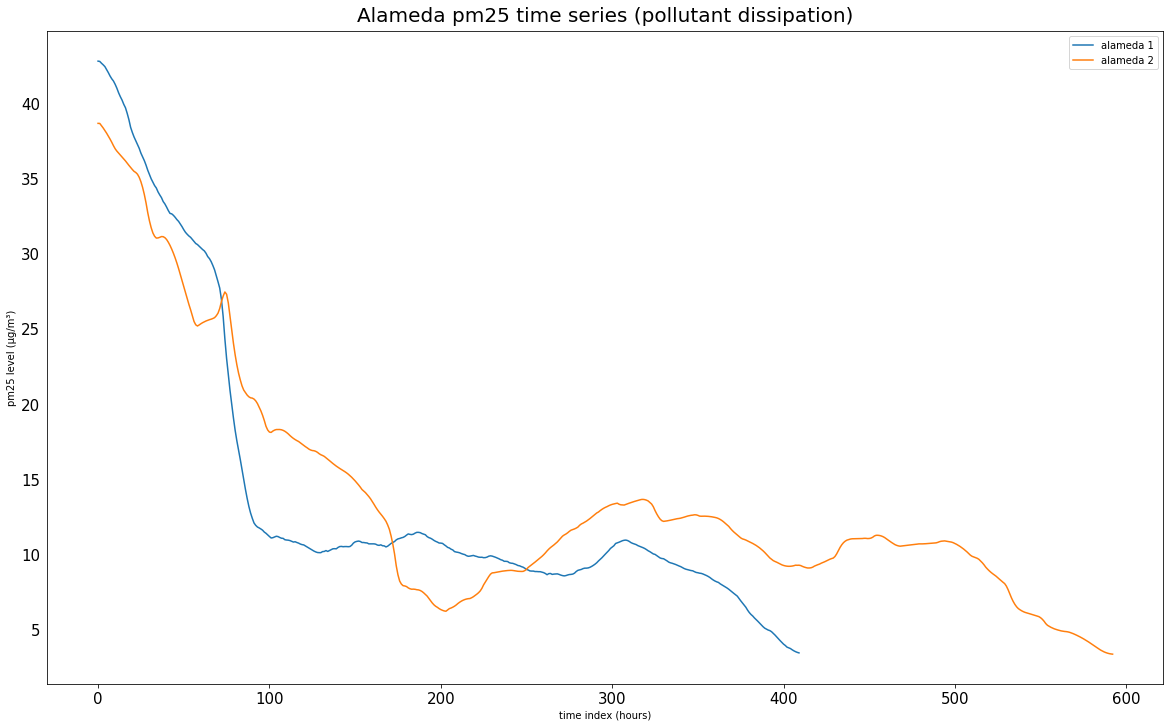

In [0]:
plt.plot(alameda_1_aq_curve, label = "alameda 1")
plt.plot(alameda_2_aq_curve, label = "alameda 2")
plt.legend()
plt.title('Alameda pm25 time series (pollutant dissipation)', fontsize = 20)
plt.ylabel('pm25 level (µg/m³)')
plt.xlabel('time index (hours)')
plt.show()

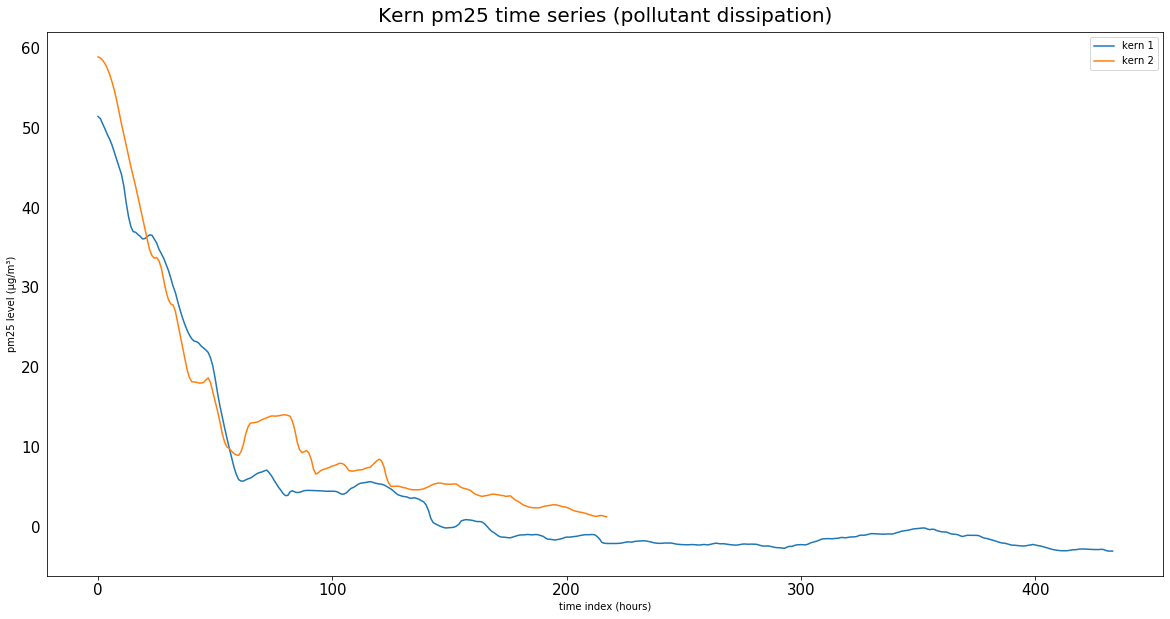

In [0]:
plt.figure(figsize = (20, 10))
plt.plot(kern_1_aq_curve, label = "kern 1")
plt.plot(kern_2_aq_curve, label = "kern 2")
plt.title('Kern pm25 time series (pollutant dissipation)', fontsize = 20)
plt.ylabel('pm25 level (µg/m³)')
plt.xlabel('time index (hours)')
plt.legend()
plt.show()

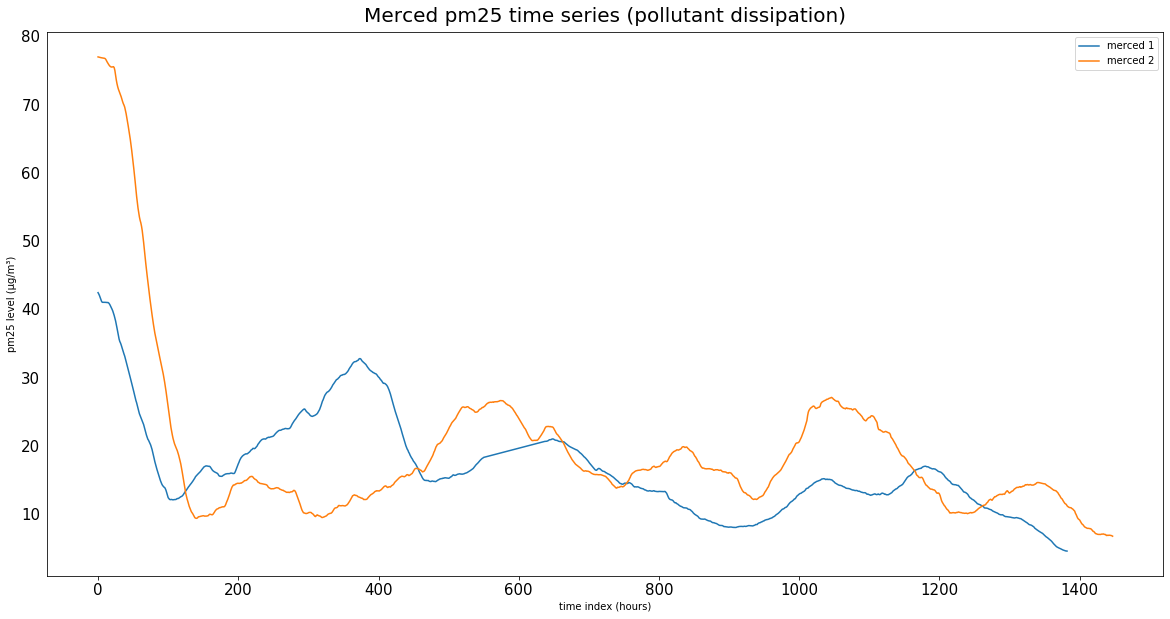

In [0]:
plt.figure(figsize = (20, 10))
plt.plot(merced_1_aq_curve, label = "merced 1")
plt.plot(merced_2_aq_curve, label = "merced 2")
plt.title('Merced pm25 time series (pollutant dissipation)', fontsize = 20)
plt.ylabel('pm25 level (µg/m³)')
plt.xlabel('time index (hours)')
plt.legend()
plt.show()

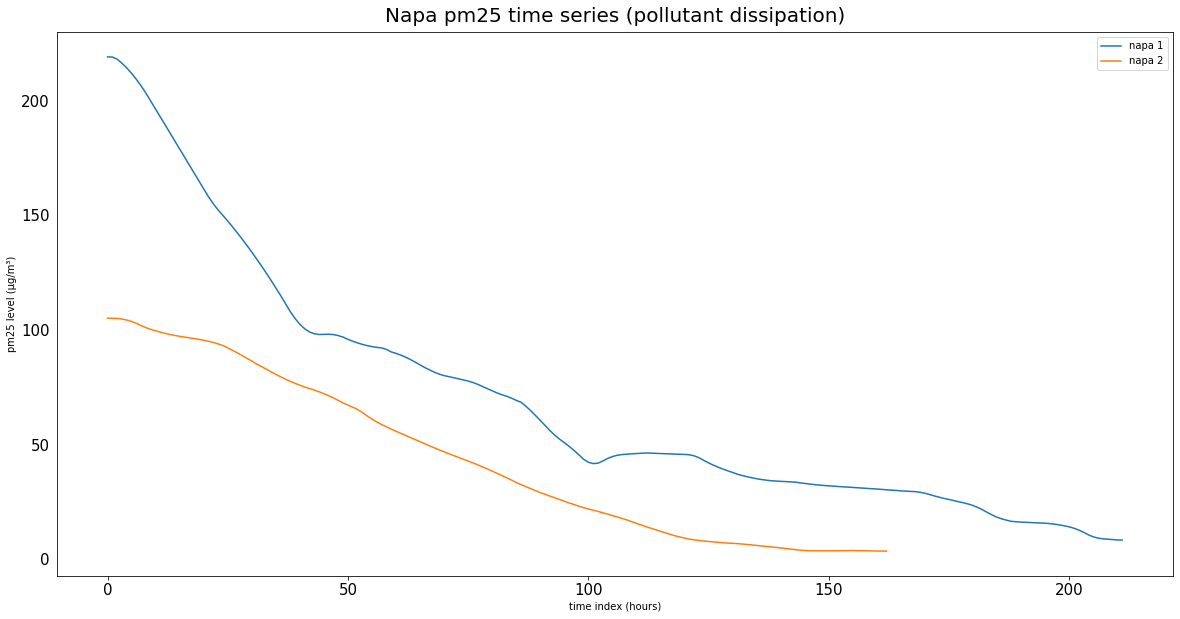

In [0]:
plt.figure(figsize = (20, 10))
plt.plot(napa_1_aq_curve, label = "napa 1")
plt.plot(napa_2_aq_curve, label = "napa 2")
plt.title('Napa pm25 time series (pollutant dissipation)', fontsize = 20)
plt.ylabel('pm25 level (µg/m³)')
plt.xlabel('time index (hours)')
plt.legend()
plt.show()

These results are interesting!  While we are desparate for more data in order to further validate our hypothesis, it seems likely that pollutant dissipation response is related to region.

.

# Modeling: Pollutant Dissipation

We will attempt to model the dissipation of pm25 over time using a Linear Regression model, as well as fitting an Exponential Curve to the data.  We will choose to focus on only one county for the sake of this project (Kern County in this case).  Future work would include expanding our analysis to all candidate counties.

The y-values have been normalized to lie between 0 and 1, and they all start at the same peak, a value of 1.0.  Thnking about the pollutant level as a percentage of peak level justifies this transformation we made to the data.  We also crop the time index (x_axis) so that the train and test sample have the same domain and range.


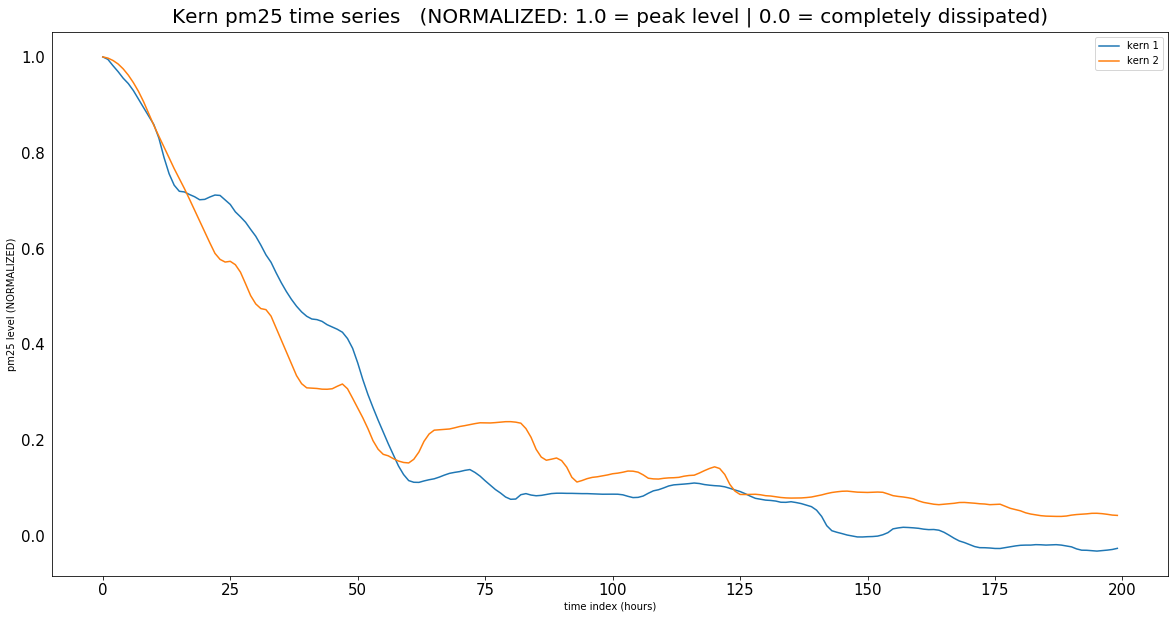

In [0]:
"""
Plot two different fires that took place in Kern County, about 7 months apart.
"""
kern_1_normalized = (kern_1_aq_curve / max(kern_1_aq_curve))[0:200]
kern_2_normalized = (kern_2_aq_curve / max(kern_2_aq_curve))[0:200]

y_train = kern_1_normalized
y_test = kern_2_normalized

plt.figure(figsize = (20, 10))
plt.plot(y_train, label = "kern 1")
plt.plot(y_test, label = "kern 2")
plt.title('Kern pm25 time series   (NORMALIZED: 1.0 = peak level | 0.0 = completely dissipated)', fontsize = 20)
plt.ylabel('pm25 level (NORMALIZED)')
plt.xlabel('time index (hours)')
plt.legend()
plt.show()

#### Fit a Linear Regression model to the data, and evaluate R2 score.

In [0]:
index = np.linspace(0, len(y_train) - 1, len(y_train)).astype(np.int64)
index = [[i] for i in index]

lr_model = LinearRegression().fit(index, y_train)
y_pred = lr_model.predict(index)
print("R^2 of Linear Regression (TRAIN is same as TEST): ", r2_score(y_train, y_pred))
print("RMSE of Linear Regression: ", mean_squared_error(y_train, y_pred))

R^2 of Linear Regression (TRAIN is same as TEST):  0.7347031595718903
RMSE of Linear Regression:  0.02161533161168448


Text(0.5, 0, 'Time Index')

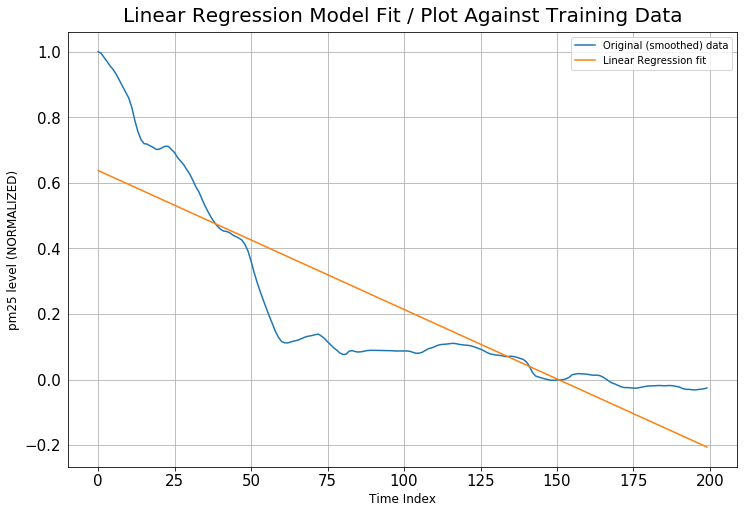

In [0]:
# PLOT RESULTS
plt.figure(figsize = (12, 8))
plt.plot(y_train, label = "Original (smoothed) data")
plt.plot(y_pred, label = "Linear Regression fit")
plt.legend()
plt.grid()
plt.title("Linear Regression Model Fit / Plot Against Training Data", fontsize = 20)
plt.ylabel("pm25 level (NORMALIZED)", fontsize = 12)
plt.xlabel("Time Index", fontsize = 12)

Now we will evaluate the linear regression against our y_test sample timeseries, and compare the R2 score. 

R^2 of Linear Regression:  0.6377769561497821
RMSE of Linear Regression:  0.02191442139262559


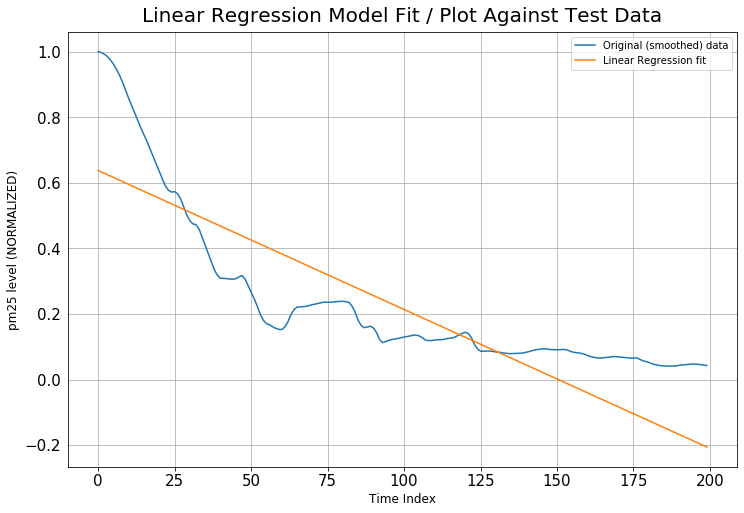

In [0]:
plt.figure(figsize = (12, 8))
plt.plot(y_test, label = "Original (smoothed) data")
plt.plot(y_pred, label = "Linear Regression fit")
plt.legend()
plt.grid()
plt.title("Linear Regression Model Fit / Plot Against Test Data", fontsize = 20)
plt.ylabel("pm25 level (NORMALIZED)", fontsize = 12)
plt.xlabel("Time Index", fontsize = 12)

print("R^2 of Linear Regression: ", r2_score(y_test, y_pred))
print("RMSE of Linear Regression: ", mean_squared_error(y_test, y_pred))

plt.show()

Not surprisingly, the R2 score for the test is lower than that for the train (obvious).  The RMR2 Score for the training fit to Linear model is 0.735, while the R2 Score for the test series is 0.638.

### Fitting an Exponential Curve

Optimal a, b, c parameters for curve fit:
 
a:  1.1124716525424634 
b:  0.02305267420418049 
c:  -0.025641874117746342 


R^2 of Curve:  0.9686473477018778
RMSE of Curve:  0.002554489436195888


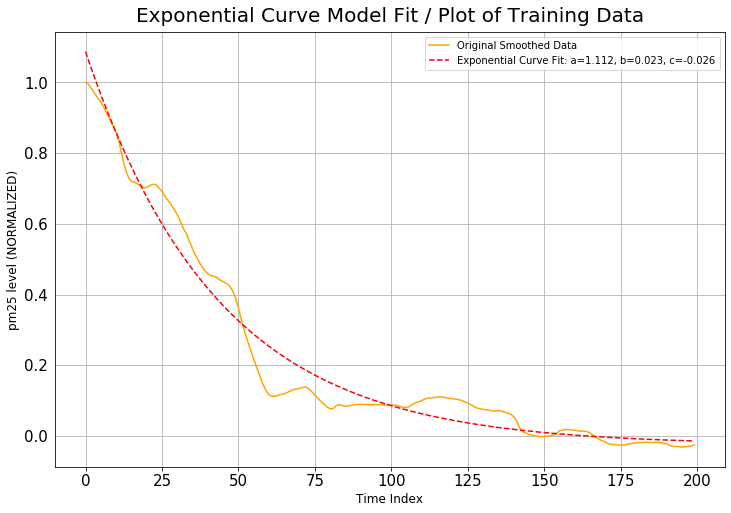

In [0]:
def func(x, a, b, c):
  return a * np.exp(-b * x) + c
  
index = np.linspace(0, len(y_train) - 1, len(y_train)).astype(np.int64)
popt, pcov = curve_fit(func, index, y_train)
print("Optimal a, b, c parameters for curve fit:\n", "\na: ", popt[0], "\nb: ", popt[1], "\nc: ", popt[2], "\n\n")

plt.figure(figsize = (12, 8))
plt.plot(index, y_train, 'b-', label = "Original Smoothed Data", color = "orange")
plt.plot(index, func(index, *popt), 'r-', label='Exponential Curve Fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt), color = "red", linestyle = "--")
plt.title("Exponential Curve Model Fit / Plot of Training Data", fontsize = 20)
plt.ylabel("pm25 level (NORMALIZED)", fontsize = 12)
plt.xlabel("Time Index", fontsize = 12)
plt.legend()
plt.grid()

print("R^2 of Curve: ", r2_score(y_train, func(index, *popt)))
print("RMSE of Curve: ", mean_squared_error(y_train, func(index, *popt)))

R^2 of Curve:  0.9337964733634152
RMSE of Curve:  0.004005300063106849


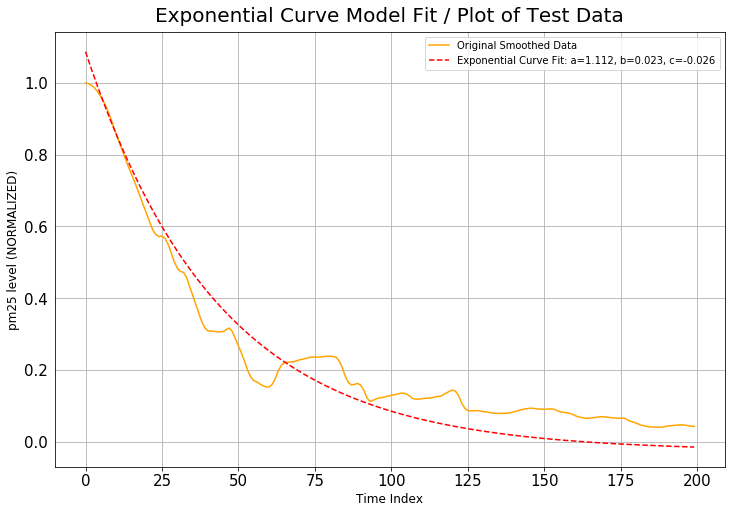

In [0]:
plt.figure(figsize = (12, 8))
plt.plot(index, y_test, 'b-', label = "Original Smoothed Data", color = "orange")
plt.plot(index, func(index, *popt), 'r-', label='Exponential Curve Fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt), color = "red", linestyle = "--")
plt.title("Exponential Curve Model Fit / Plot of Test Data", fontsize = 20)
plt.ylabel("pm25 level (NORMALIZED)", fontsize = 12)
plt.xlabel("Time Index", fontsize = 12)
plt.legend()
plt.grid()

print("R^2 of Curve: ", r2_score(y_test, func(index, *popt)))
print("RMSE of Curve: ", mean_squared_error(y_test, func(index, *popt)))

As we can see, the exponential curve produces a much better fit!  We have only evaluated the error of our exponential model on a single test series because, quite frankly, we don't have more data.  This is a similar story with pretty much all of the locations contained within our dataset.  However, we see the potential impact that a model of dissipation such as this could have on estimating safe air breathing conditions.

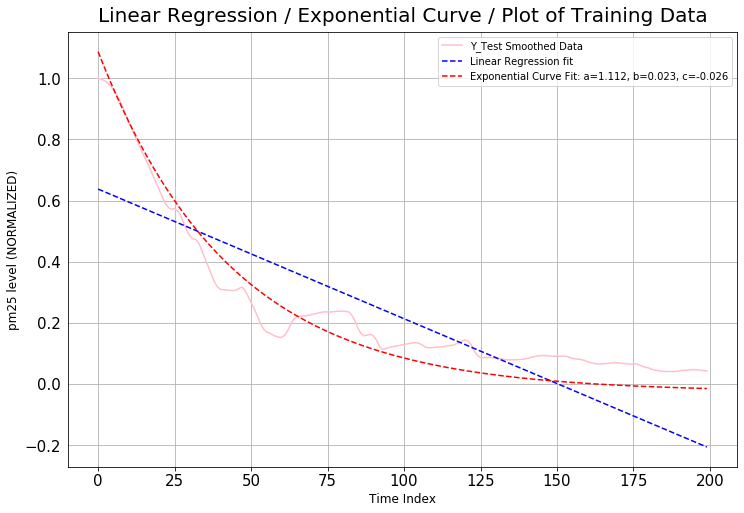

In [0]:
plt.figure(figsize = (12, 8))
plt.plot(index, y_test, 'b-', label = "Y_Test Smoothed Data", color = "pink")

plt.plot(y_pred, label = "Linear Regression fit", color = "blue", linestyle = "--")
plt.plot(index, func(index, *popt), 'r-', label='Exponential Curve Fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt), color = "red", linestyle = "--")
plt.title("Linear Regression / Exponential Curve / Plot of Training Data", fontsize = 20)
plt.ylabel("pm25 level (NORMALIZED)", fontsize = 12)
plt.xlabel("Time Index", fontsize = 12)
plt.legend()
plt.grid()

# Conclusion

We have shown that the California Air Quality dataset does indeed contain somewhat robust signal reponse to wildfire events taking place.  One of the main challenges we faced is the lack of abundant data.  Since wildfires are relatively sparsely occurring events, it is necessary to perform significant data exploration and visualization in order to extract meaning.  In order to be useful in practice, multiple models should likely be built for a given region, and for varying degrees/scale of fire.